In [1]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('../lib/')
import matplotlib.pyplot as plt
from find_stars_isolated import *
from utils import get_fits_file, latex_settings

# Reading FITS files of F606w

In [2]:
filepath_data = '../Data/FITS/'
wavelen='F606w'
# Get images as 2-D numpy array from FITS file of F606w
fits_f606, image_f606 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F606w fits file
fits_f606.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   


Filter out all negative values for the intensity because they don't have physical meaning.

In [3]:
image = image_f606.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15048535457778456


Read stars dataset

In [4]:
names = ['ID', 'Xcor', 'Ycor', 'F606', 'eF606',
         'F814', 'eF814', 'chi', 'sharp']

filepath_data = '../Data/Catalog/' 
file = os.listdir(filepath_data)[0]
data = pd.read_csv(filepath_data + file, names=names,
                   delim_whitespace=True, skiprows=1)

data

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720
...,...,...,...,...,...,...,...,...,...
51475,899987,3417.467,10394.319,26.895,0.0783,25.602,0.1050,9.508,1.3140
51476,900088,3435.031,10396.730,23.152,0.0504,22.662,0.0505,8.823,-0.1330
51477,900094,3594.567,10397.340,27.209,0.0815,27.130,0.0900,4.311,0.9355
51478,900176,5155.093,10397.920,28.235,0.0984,26.477,0.0937,6.173,0.3190


Find all image's points with intensity values in a choosen range.

Motivate the choice for the intensity values:
for now we choose interval \[950, 1000\] in order to avoid the superposition of more stars that have high intensity

In [5]:
%%time

ids = find_coords_from_image(950, 1000, image)
ids.shape

CPU times: user 1.14 s, sys: 142 ms, total: 1.28 s
Wall time: 1.28 s


(39081, 2)

 Plotting comparison between all stars and filtered ones.

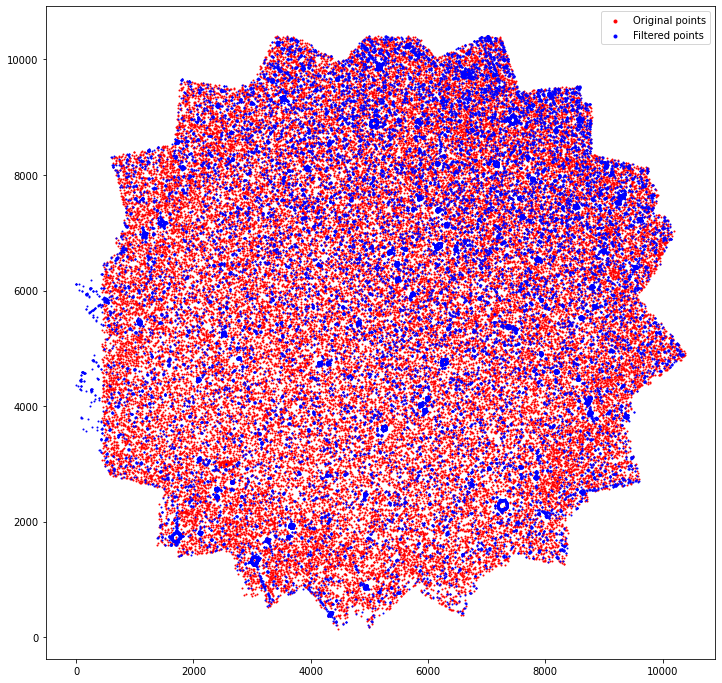

In [6]:
plt.figure(figsize=(12, 12))
plt.scatter(data['Xcor'], data['Ycor'], s=1, c='r', label='Original points')
plt.scatter(ids[:,0], ids[:,1], s=1, c='b', label='Filtered points')
plt.legend(markerscale=3)

In order to further filter the points and find isolated stars, we use graph-tool package. 
Create a geometric graph where all the coordinates found before are vertices. This points are connected in an euclidean space which are at a distance equal to or smaller than a given radius.

In [7]:
%%time

bb = 15.
dist = np.sqrt(2) * bb
g = geometric_graph_stars(coords=ids, distance=dist)

g

CPU times: user 1.97 s, sys: 33.7 ms, total: 2.01 s
Wall time: 664 ms


<Graph object, undirected, with 39081 vertices and 223414 edges, 2 internal vertex properties, at 0x7fdeebf22b00>

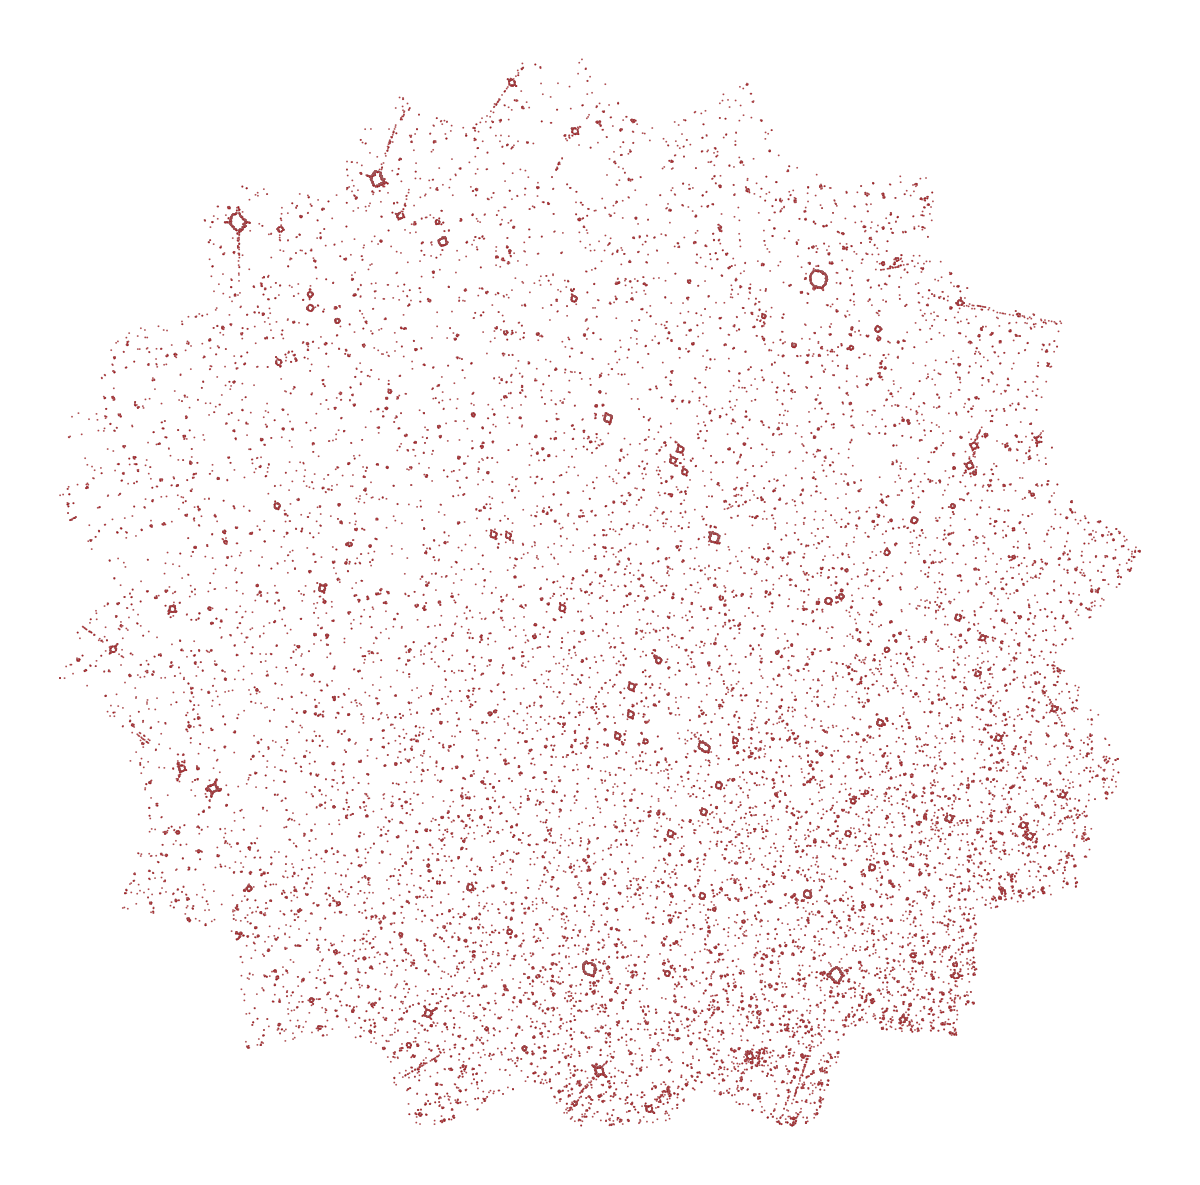

CPU times: user 10.8 s, sys: 60.7 ms, total: 10.9 s
Wall time: 10.3 s


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdeebf22b00, at 0x7fdeebf22d40>

In [8]:
%%time

filepath_images = '../Images/'
graph_draw(g=g, pos=g.vp.pos)
#save_graph_plot(Graph=g, file=filepath_images + f'geometric_graph_{wavelen}.png')

In [9]:
%%time


# Filter out all vertices with at least 1 edge.
gv = GraphView(g, vfilt=g.degree_property_map("out").a==0)
gv

CPU times: user 32 ms, sys: 1.82 ms, total: 33.8 ms
Wall time: 10.8 ms


<GraphView object, undirected, with 4017 vertices and 0 edges, 2 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fdeebf23430, at 0x7fdeebf237c0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fdeebf23430, at 0x7fdeebf236a0>, False), at 0x7fdeebf23430>

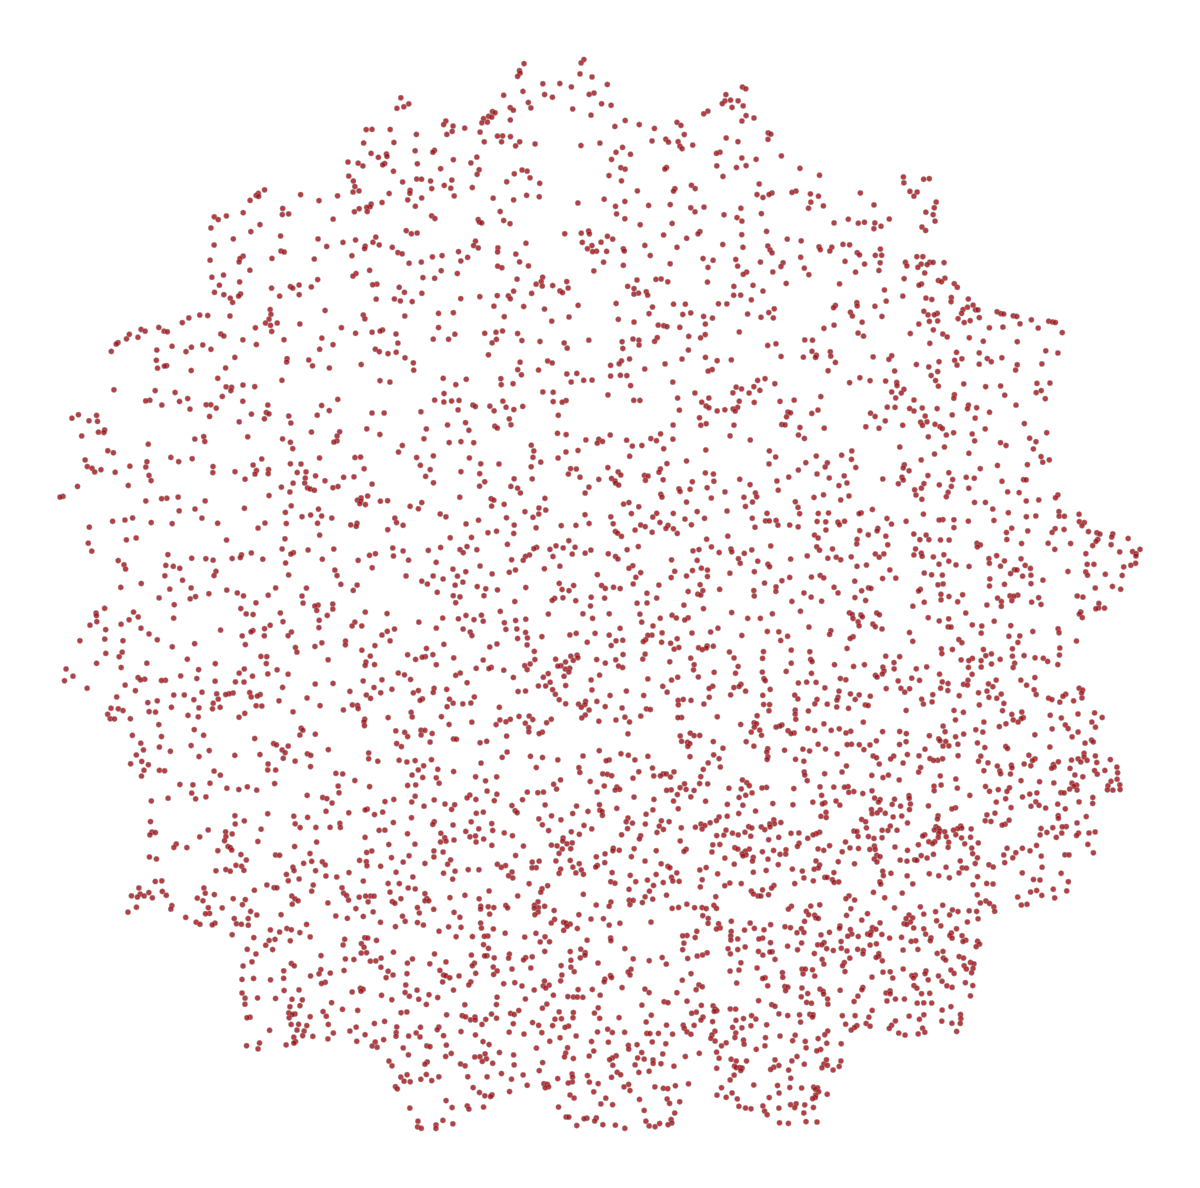

CPU times: user 955 ms, sys: 15.7 ms, total: 971 ms
Wall time: 710 ms


In [10]:
%%time


filepath_images = '../Images/'
graph_draw(gv, gv.vp.pos)
#save_graph_plot(Graph=gv, file=filepath_images + f'geometric_graph_noedges_{wavelen}.png')
plt.close()

In [11]:
%%time

ids_filt = gv.vp.pos.get_2d_array([0, 1]).T

del g, gv

CPU times: user 79.7 ms, sys: 18.9 ms, total: 98.5 ms
Wall time: 20.2 ms


In [12]:
cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()

Find all stars ID in the dataset with the closest coordinates respect the image indexis position.

In [13]:
%%time


IDs_filt = find_IDs_from_data(dataset=cor, ids=ids_filt, npixel=2.)
len(IDs_filt)

CPU times: user 2.98 s, sys: 59.1 ms, total: 3.04 s
Wall time: 3.15 s


1182

With the jit compiled function find_IDs_jit(), we obtain a speed up of around 20% respect to find_IDs().

In [14]:
len(np.unique(IDs_filt[:,0]))

1182

In [15]:
df = pd.DataFrame(IDs_filt, columns=['ID', 'Xcor', 'Ycor'])
df = df.astype('int32')
filepath_results = '../Results/'
df.to_csv(filepath_results + f'ID_coords_image_{wavelen}.csv', index=False)

df

,ID,Xcor,Ycor
0,7873,4703,542
1,12547,3284,633
2,13066,4497,644
3,23114,4082,780
4,23342,5892,782
...,...,...,...
1177,893600,5870,10241
1178,894495,6753,10257
1179,897539,7124,10323
1180,898640,5807,10352


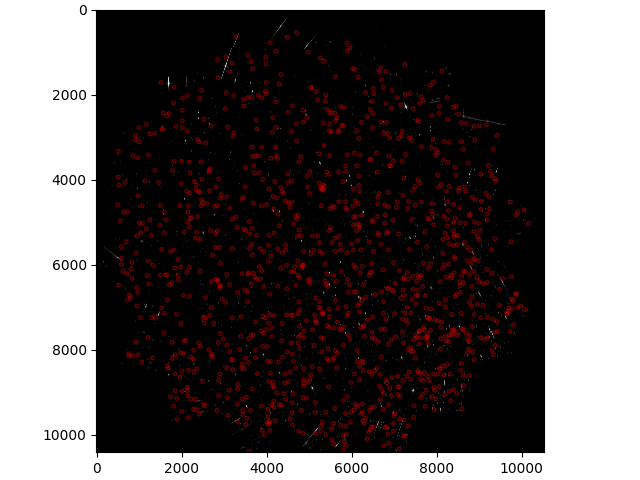

In [16]:
%matplotlib widget
fig, ax = latex_settings()

ax.imshow(image, cmap='gray')
ax.scatter(data.loc[data.ID.isin(IDs_filt[:, 0]), 'Xcor'], 
            data.loc[data.ID.isin(IDs_filt[:, 0]), 'Ycor'],
            color='b', s=0.1, marker=',', label='Dataset pts')
ax.scatter(IDs_filt[:,1], IDs_filt[:,2], alpha=0.4, marker='o', color='r',
           fc='None', s=6., label='Image pts')
plt.show()
filepath_images = '../Images/'
plt.savefig(filepath_images + f'stars_ID_identified_{wavelen}.png',
            dpi=800, transparent=True)